# Vehicle Detection
To detect vehicles in images we will perform the following steps:
    1. HOG detection
    2. Color feature extraction
    3. Data preparation
    4. Classifier training
    5. Sliding window implementation
    6. Search and Classify
    7. Multiple Detection and reduce false positives
    8. Creating a pipeline to detect objects in a movie 

## HOG Detection
To perform Histogram Orientation Detection (HOG) we have multiple parameters to pick. First we have to choose the colorspace. We found in literature that YCrCb is a popular color space. This is described in [Creusen et al., 2010](https://pure.tue.nl/ws/files/3283178/Metis245392.pdf) where the authors describe that the best traffic sign detection are found by means of the CIELab and YCrCb color space. In [Baghel et al., 2017](http://www.ijcaonline.org/archives/volume134/number7/23927-2016907926) the authors have success removing shadow using YCrCb color space. As such we are interested in creating a HOG feature map for the Cb and the Cr channgels. Since the Y channel in YCrCb encodes a grayscale image we will use that image for our HOG detection.

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import os

In [4]:
%matplotlib inline

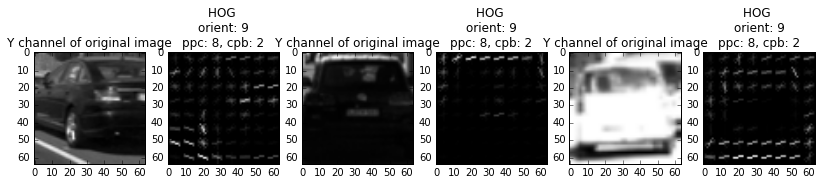

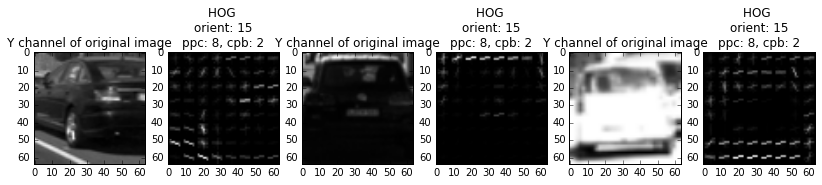

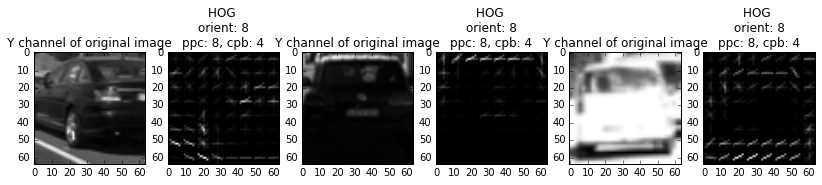

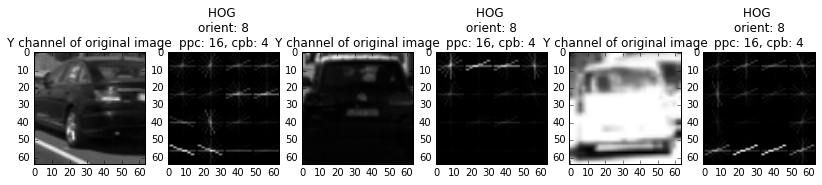

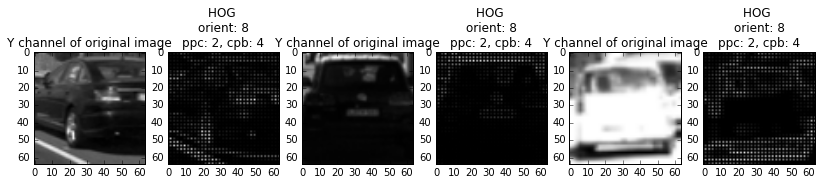

In [17]:
def plot_hog_sample(images, orient, pix_per_cell, cell_per_block):
    num_img = len(images) * 20
    img_idx = 1
    fig = plt.figure(figsize=(14,6))
    for image_name in images:
        img = cv2.imread(image_name)
        # Read the image and convert it to YCrCb color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        img_Y = img[:,:,0]
        img_Y = img_Y.astype(np.float64)
        feature, hog_image = hog(img_Y, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        plt.subplot(100 + num_img + img_idx)
        img_idx += 1
        plt.title('Y channel of original image')
        plt.imshow(img_Y, cmap='gray')
        plt.subplot(100 + num_img + img_idx)
        img_idx += 1
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG \norient: %s\nppc: %s, cpb: %s' %
                 (orient, pix_per_cell, cell_per_block))

test_images = ['.' + os.sep + 'vehicles' + os.sep + 'GTI_Right' +os.sep + 'image0003.png', 
               '.' + os.sep + 'vehicles' + os.sep + 'KITTI_extracted' +os.sep + '108.png',
               '.' + os.sep + 'vehicles' + os.sep + 'KITTI_extracted' +os.sep + '249.png' ]
plot_hog_sample(test_images, 9, 8, 2)
# Let us increase the orientation bins. The drawback of having more orientation bins is that the 
# classifier will need to learn more features.
plot_hog_sample(test_images, 15, 8, 2)
# Let us decrease the orientation bins to 8 and increase the cell per block
plot_hog_sample(test_images, 8, 8, 4)
# Let us also increase the pixels per cell
plot_hog_sample(test_images, 8, 16, 4)
# Let us decrease the pixels per cell
plot_hog_sample(test_images, 8, 2, 4)

We see from altering the parameters that our initial parameters were actually quite good. As described in [Ballesteros et al., 2014](http://www.eurasip.org/Proceedings/Eusipco/Eusipco2014/HTML/papers/1569924423.pdf) the optimal number of cell blocks for SVM classifier depends on whether an object is at the right, center or left and near or far. We see that 8 orientation bins is optimal with 4 cells per block size 2. We see from the last row of images that this leads to a large grid which may complicate the computation at a later stage. For now we will however continue with these value.

## Color Feature Extraction
We used HOG on the Y channel of the YCrCb encoding. We will encode the Cr and Cb channels with a histogram and perform normalization.

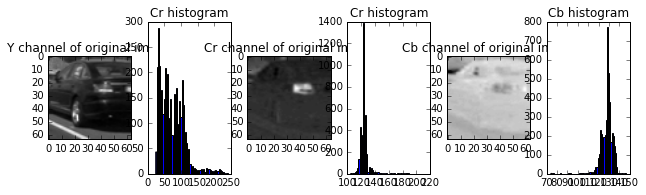

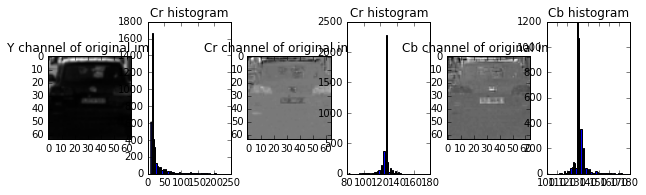

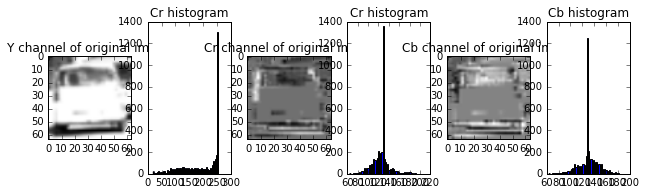

In [18]:
def histograms(img, size = 64):
    features = cv2.resize(img, (size, size)).ravel()
    return features
   
def plot_hist_sample(images):
    num_img = len(images) * 60
    for image_name in images:
        # Read the image and convert it to YCrCb color space
        fig = plt.figure(figsize=(14,6))
        img = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2YCR_CB)
        img_Y = img[:,:,0].astype(np.float64)
        feature = histograms(img_Y)
        img_idx = 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Y channel of original image')
        plt.imshow(img_Y, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 64)
        plt.title('Cr histogram')
        img_Cr = img[:,:,1].astype(np.float64)
        feature = histograms(img_Cr)
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Cr channel of original image')
        plt.imshow(img_Cr, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 64)
        plt.title('Cr histogram')
        img_Cb = img[:,:,2].astype(np.float64)
        feature = histograms(img_Cb)
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Cb channel of original image')
        plt.imshow(img_Cb, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 64)
        plt.title('Cb histogram')
        
plot_hist_sample(test_images)

We see that we get interesting peaks in the histograms and that even standardized they cannot be substituted. This is particularly clear in the first figure. The histogram of the Cr channel is skewed to the left whereas the Cb channel is skewed to the left. We will therefore use all three.

## Combining Features
Next we combine the features that we extracted above. We first compute all the features and scale the entire concatenated feature vector at once. We will see however that this leads to outliers showing up and all HOG features to dissappear. In our second attempt we standardize the YCrCb features and the HOG features separately. This leads to more variation.

To reduce outliers we isolate the distribution of colors in the Y, Cr and Cb channels instead of looking at absolute count.

In [12]:
def color_hist(img, nbins=32, bins_range=(0,256)):
    Y_channel = np.histogram(img[:,:,0], bins=nbins, range=bins_range, density=True)
    Cr_channel = np.histogram(img[:,:,1], bins=nbins, range=bins_range, density=True)
    Cb_channel = np.histogram(img[:,:,2], bins=nbins, range=bins_range, density=True)
    hist_feature = np.concatenate((Y_channel[0], Cr_channel[0], Cb_channel[0]))
    return hist_feature

def hog_features_extract(img, orient=8, pix_per_cell=8, cell_per_block=2, feature_vec=True):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=False, feature_vector=feature_vec)
    return features
 

def extract_features(img, size=64):
    img = cv2.resize(img, (size, size))
    hog_feat = hog_features_extract(img[:,:,0])
    color_feat = color_hist(img)
    all_features = np.concatenate((hog_feat, color_feat))
    return all_features

orient = 8
pix_per_cell = 8
cell_per_block = 2

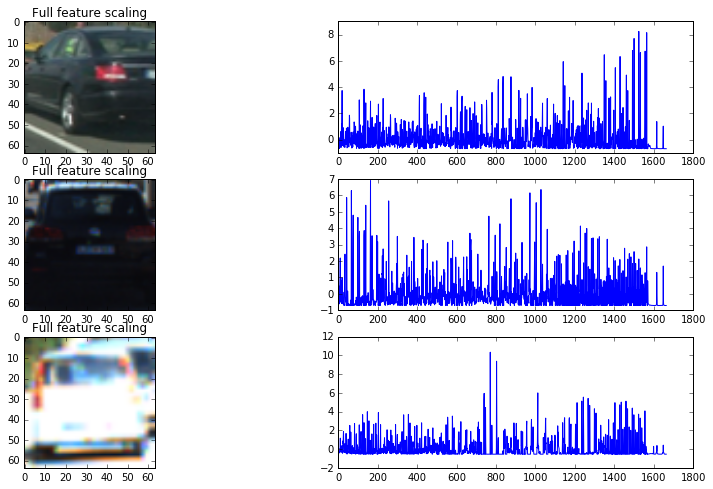

In [20]:
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

def plot_features_norm_all(images):
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(len(images),2)
    for i, image_name in enumerate(images):
        # Read the image and convert it to YCrCb color space
        img = cv2.imread(image_name)
        img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        ax = plt.subplot(gs[i * 2])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        features = extract_features(img_conv)
        features = features.reshape(-1, 1).astype(np.float64)
        scaler = StandardScaler().fit(features)
        scaled_features = scaler.transform(features)
        plt.title('Full feature scaling')
        ax = plt.subplot(gs[i * 2 + 1])
        ax.plot(scaled_features)
   
    return None
       
plot_features_norm_all(test_images)

We see that piecewise scaling yields the HOG features, which are more on the left part of the graph, as well as the YCrCb features, which are more on the right, to show up in equal amounts.

In [8]:
import glob

car_features = []
noncar_features = []

for img_fn in glob.iglob('vehicles/**/*png'):
    img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2YCR_CB)
    car_features.append(extract_features(img))

for img_fn in glob.iglob('non-vehicles/**/*png'):
    img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2YCR_CB)
    noncar_features.append(extract_features(img))

## Inspect Training Size
Let us first inspect the amount of training data that we have. This should be equal to ensure that the model will not only learn the features associated with one category.

In [9]:
print("Size of car features: %s" % len(car_features))
print("Size of non car features: %s" % len(noncar_features))

Size of car features: 8792
Size of non car features: 8968


We have a bit more non car features. Since we care more about cars we will drop at random some non car images to ensure that both have the same dimension.

In [10]:
# Create training labels
noncar_features = np.stack(noncar_features[:len(car_features)])
car_features = np.stack(car_features)

print(noncar_features.shape)
print(car_features.shape)

(8792, 1664)
(8792, 1664)


In [11]:
N = 8792
x = np.append(car_features[:N], noncar_features[:N], axis=0)
scaler = StandardScaler().fit(x)
X_scaled = scaler.transform(x)
print(X_scaled.shape)

(17584, 1664)


In [12]:
y = np.hstack((np.ones(car_features[:N].shape[0]), np.zeros(noncar_features[:N].shape[0])))
print(y.shape)

(17584,)


## Machine Learning Pipeline
We can now execute the machine learning pipeline. With the HOG features and the histograms we have 384 variables per image. It is likely that some of these variables will be more important than others. For this reason we decide to create a machine learning pipeline. The first stage of that pipeline consists of a Principal Component Analysis (PCA). The second consists of Support Vector Machine (SVM) with a Radial Basis Function (RBF) kernel. Both PCA as well as the SVM have parameters that can be varied to reach the best performance. For that reason we decide to perform a grid search to search for the the optimal values of these parameters.

For PCA we seek the optimal number of dimensions. We try ten, fifty, 25 percent and fifty percent of the total number of variables. For the SVM we vary the $C$ and $gamma$. The former reduces the risk of overfitting since it permits to tune the amount of penalization of misclassification and margin errors. The $gamma$ defines the impact of a single training sample. To ensure that if we observe a high model performance this is not due to how we sampled we do a k-fold cross validation with 3 folds and a test size of twenty percent. We use the F1 score to score each model.

We are required to train 720 models as part of our grid search. Due to the large amount of data and large number of models we wrote the script 'train_model.py' to be run on a large AWS instance. For our purpose we used a node with 64 CPUs. Once done we will load the results from the pickle.

In [10]:
train_on_node = False

if train_on_node:
    from sklearn.svm import SVC
    import sklearn.metrics as metrics
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.model_selection import GridSearchCV
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA, SparsePCA

    pipe = Pipeline([
        ('reduce_dim', PCA()),
        ('classify', SVC())
    ])

    #N_FEATURES_OPTIONS = [10, 50, int(X_scaled.shape[1] * .25), int(X_scaled.shape[1] * .5)]
    N_FEATURES_OPTIONS = [90, 100, 110]
    # Define the range over which the grid should search, currently at 5 can be increased.
    param_grid = {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': [5e4, 1e5, 5e5],
        'classify__gamma': [0.001, 0.005, 0.01], }

    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, verbose=2, n_jobs=4, 
                        pre_dispatch='n_jobs', 
                        scoring=metrics.make_scorer(metrics.scorer.f1_score, average="binary"))
    clf = grid.fit(X_scaled, y)
else:
    import pickle
    
    [grid, clf] = pickle.load(open('model.p', 'rb'))

In [11]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'reduce_dim__n_components': 3488, 'classify__gamma': 0.001, 'classify__C': 1000.0, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=3488, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)} with a score of 0.83


## Locating Object in Frame
We extracted three frames in which we will locate cars. This will also allow us to work on the algorithm that will recognize objects in a movie. First we use the `slide_window()`, `draw_box()` and `search_windows()` functions from the course. We adjust these to match our steps described above.

In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):
    """Search in windows in the image whether the classifier can predict 1.
    
    params:
    img      an image in RGB color space
    windows  a list of windows that should be searched
    clf      a classifier that predicts 1 or 0
    scaler   a scaler to transform the features"""
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [13]:
import time
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(3,1)
tic = time.perf_counter()
for i, img_nm in enumerate(glob.iglob('*jpg')):
    img = plt.imread(img_nm)
    windows = slide_window(img)
    pos_windows = search_windows(img, windows, clf, scaler)
    img_clf = draw_boxes(img, pos_windows)
    ax = plt.subplot(gs[i])
    plt.imshow(img_clf)
    
toc = time.perf_counter()
print("Time taken: %s" % (toc - tic))
    

NameError: name 'gridspec' is not defined

We apply the classifier over various images and see that the classifier takes 3.31 seconds to compute three images. This can be improved by calculating the HOG feature just once as we will do below.

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCR_CB)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog = hog_features_extract(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_feat, hist_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5

In [ ]:
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(3, 1)
tic = time.perf_counter()
for i, img_nm in enumerate(glob.iglob('*jpg')):
    img = plt.imread(img_nm)
    img = find_cars(img, ystart, ystop, scale, clf, scaler, orient, 
                    pix_per_cell, cell_per_block)
    ax = plt.subplot(gs[i])
    plt.imshow(img)
    
toc = time.perf_counter()
print("Time taken %s" % (toc - tic))

We see that the new implementation takes only 1.44 second to perform the same computation as we did before. This is a significant speed improvement. We see that some false positives are classified in the image above. Next we will perform a heatmap calculation to label the entire car and remove false positives.

In [70]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def apply_heat(img, box_list):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return [draw_img, heatmap]

label_img = 0

def store_labels(img, labels):
    global label_img
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        selection = img[bbox[0], bbox[2]]
        filename = "img_%s.png" % label_img
        label_img += 1
        cv2.imwrite(filename, selection)
    # Return the image
    return img       

def apply_heat_store_labels(img, box_list):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    store_labels(img, labels) 
    
    return [draw_img, heatmap]
    

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_labels(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    org_img = np.copy(img)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCR_CB)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog = hog_features_extract(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    # Initiale list of windows.
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_feat, hist_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # Add new window to list of windows.
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                # TODO: remove
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 


    # Let us do a heat map to see where we can identify cars.
    labels, heatmap = apply_heat(org_img, windows)
    return [draw_img, labels, heatmap]
    
ystart = 400
ystop = 656
scale = 2
    

In [ ]:
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(3, 3)
tic = time.perf_counter()
for i, img_nm in enumerate(glob.iglob('*jpg')):
    img = plt.imread(img_nm)
    img, labels, heatmap = find_labels(img, ystart, ystop, scale, clf, scaler, orient, 
                    pix_per_cell, cell_per_block)
    ax = plt.subplot(gs[3 * i])
    plt.imshow(img)
    ax = plt.subplot(gs[3 * i + 1])
    plt.imshow(labels)
    ax = plt.subplot(gs[3 * i + 2])
    plt.imshow(heatmap)
    
toc = time.perf_counter()
print("Time taken %s" % (toc - tic))

We apply the heatmap and see that we can eliminate some false positives. Others are harder to eliminate and remain to be done.

In [ ]:
def pipeline(img):
    movie_shot, labels, heatmap = find_labels(img, ystart, ystop, scale, clf, scaler, orient, 
                                              pix_per_cell, cell_per_block) 
    return labels

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clf_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) 
%time white_clip.write_videofile(clf_output, audio=False)

In [ ]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(clf_output))

## Observations
We see that the model has a considerable amount of false positives. For that reason we will build a better pipeline. We will first use more bins for the color histogram and remove the density. We also add HOG and spatial features for each channel in YCrCb color space. We found that the RBF SVM that we used previously is very slow on large data sets. We therefore change to the LinearSVC in sklearn. This classifier performs much better and is much faster. Moreover, we remove PCA because LinearSVC is very robust. We also add the scaler to the sklearn pipeline. The model is now trained using the file `train_model.py`.

In [61]:
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

def color_hist_no_dens(img, nbins=64, bins_range=(0,256)):
    Y_channel = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    Cr_channel = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    Cb_channel = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_feature = np.concatenate((Y_channel[0], Cr_channel[0], Cb_channel[0]))
    return hist_feature

def bin_spatial(img):
    Y = img[:,:,0].ravel()
    Cr = img[:,:,1].ravel()
    Cb = img[:,:,2].ravel()
    return np.hstack((Y, Cr, Cb))

def extract_features(img, size=64):
    img = cv2.resize(img, (size, size))
    hog_feat = hog_features_extract(img[:,:,0])
    color_feat = color_hist_no_dens(img)
    spatial_feat = bin_spatial(img)
    return [np.asfarray(hog_feat), 
            np.asfarray(color_feat), 
            np.asfarray(spatial_feat)]

orient = 8
pix_per_cell = 8
cell_per_block = 2

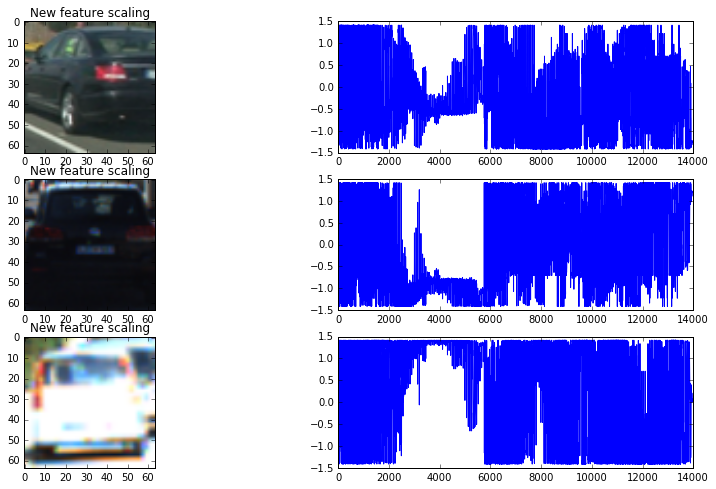

In [26]:
# Let us first iterate through the images
features = []
for image_name in test_images:
    hog_f, color_f, spatial_f = extract_features(cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2YCR_CB))
    features.append(np.concatenate((hog_f, color_f, spatial_f)))
    
# Let us concatenate again and scale again
feat = np.stack(features)
feat_scaler = StandardScaler().fit(feat)
feat = feat_scaler.transform(feat)


fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(len(test_images),2)
for i, image_name in enumerate(test_images):
    # Read the image and convert it to YCrCb color space
    img = cv2.imread(image_name)
    img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    ax = plt.subplot(gs[i * 2])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('New feature scaling')
    ax = plt.subplot(gs[i * 2 + 1])
    ax.plot(feat[i])

We see that the the feature space has increased, because we added additional features, but that the the the space looks much more unit. This is much better than what we started out with because a support vector machine assume that the data has mean variance and mean.

In [102]:
import pickle
    
[org_clf, grid] = pickle.load(open('original_classifier.p', 'rb'))

In [55]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'classify__C': 0.5} with a score of 0.99


In [96]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_labels_full_feat(img, ystart, ystop, scale, svc, orient, pix_per_cell, 
                             cell_per_block, heat_func):
    org_img = np.copy(img)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCR_CB)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog_Y = hog_features_extract(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog_Cr = hog_features_extract(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog_Cb = hog_features_extract(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    # Initiale list of windows.
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get histogram features
            hist_feat = np.asfarray(color_hist_no_dens(subimg))
            # Get spatial features
            spatial_feat = np.asfarray(bin_spatial(subimg))
            
            # Extract HOG for this patch and transform it.
            hog_Y_feat = hog_Y[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_Cr_feat = hog_Cr[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_Cb_feat = hog_Cb[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat = np.concatenate((hog_Y_feat, hog_Cr_feat, hog_Cb_feat))

            # Scale features and make a prediction
            test_feat = np.concatenate((hog_feat, hist_feat, spatial_feat), axis=0).reshape(1,-1)
            test_prediction = svc.predict(test_feat)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # Add new window to list of windows.
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                # TODO: remove
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 


    # Let us do a heat map to see where we can identify cars.
    labels, heatmap = heat_func(org_img, windows)
    return draw_img, labels, heatmap
    
ystart = 400
ystop = 656
scale = 1.5

Time taken 2.1668085909914225


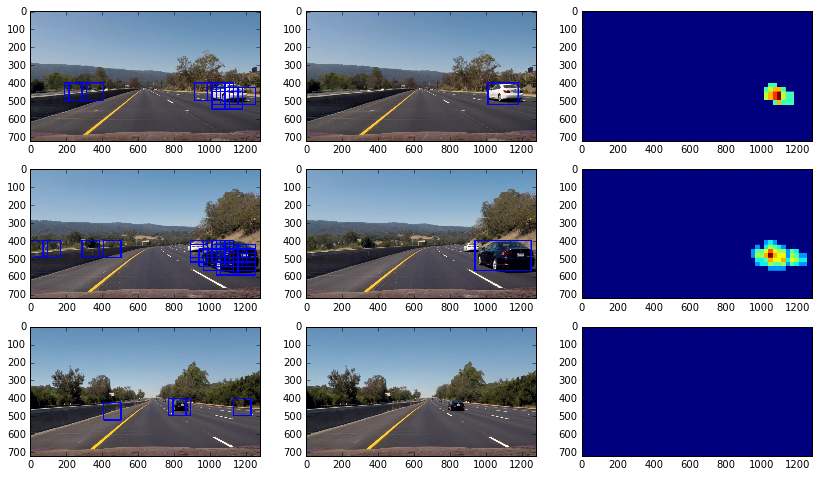

In [103]:
import matplotlib.gridspec as gridspec
import time
import glob

fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(3, 3)
tic = time.perf_counter()
for i, img_nm in enumerate(glob.iglob('*jpg')):
    img = plt.imread(img_nm)
    img, labels, heatmap = find_labels_full_feat(img, ystart, ystop, scale, svc=org_clf, 
                                                    orient=8,  
                                                 pix_per_cell=8,  
                                                 cell_per_block=2, heat_func=apply_heat)
    ax = plt.subplot(gs[3 * i])
    plt.imshow(img)
    ax = plt.subplot(gs[3 * i + 1])
    plt.imshow(labels)
    ax = plt.subplot(gs[3 * i + 2])
    plt.imshow(heatmap)
    
toc = time.perf_counter()
print("Time taken %s" % (toc - tic))


We see that we still have some wrong classifications. Lets run through the entire movie and store the images to a directory. We will then classify the images manually to improve our classifier.

In [93]:
label_img = 0

def store_labels(img, labels):
    global label_img
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        selection = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        filename = "recognized_images/img_%s.png" % label_img
        label_img += 1
        cv2.imwrite(filename, cv2.cvtColor(selection, cv2.COLOR_BGR2RGB))
    # Return the image
    return img       

def apply_heat_store_labels(img, box_list):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    store_labels(img, labels) 
    
    return [draw_img, heatmap]

In [94]:
def pipeline_store_img(img):
    movie_shot, labels, heatmap = find_labels_full_feat(img, ystart, ystop, scale, clf, 
                                                        orient,  pix_per_cell, 
                                                        cell_per_block, apply_heat_store_labels) 
    return labels

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clf_output = 'project_video_out_new.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_store_img) 
%time white_clip.write_videofile(clf_output, audio=False)

[MoviePy] >>>> Building video project_video_out_new.mp4
[MoviePy] Writing video project_video_out_new.mp4










  0%|          | 0/1261 [00:00<?, ?it/s]







  0%|          | 1/1261 [00:00<07:48,  2.69it/s]







  0%|          | 2/1261 [00:00<07:48,  2.69it/s]







  0%|          | 3/1261 [00:01<08:02,  2.61it/s]







  0%|          | 4/1261 [00:01<08:11,  2.56it/s]







  0%|          | 5/1261 [00:01<08:17,  2.52it/s]







  0%|          | 6/1261 [00:02<08:29,  2.46it/s]







  1%|          | 7/1261 [00:02<08:27,  2.47it/s]







  1%|          | 8/1261 [00:03<08:19,  2.51it/s]







  1%|          | 9/1261 [00:03<08:25,  2.48it/s]







  1%|          | 10/1261 [00:03<08:20,  2.50it/s]







  1%|          | 11/1261 [00:04<08:24,  2.48it/s]







  1%|          | 12/1261 [00:04<08:25,  2.47it/s]







  1%|          | 13/1261 [00:05<08:17,  2.51it/s]







  1%|          | 14/1261 [00:05<08:10,  2.54it/s]







  1%|          | 15/1261 [00:05<07:57,  2.61it/s]







  1%|▏         | 16/1261 [00:06<07:49,  2.65it/s]







  1%|▏         | 17/1261 [00:06<07:55,  2

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_new.mp4 

CPU times: user 7min 45s, sys: 26.4 s, total: 8min 12s
Wall time: 8min 16s


### Hard Negative Mining
We categorize all the images that were identified and add this to the training data. Next we retrain the model. We also improved the training code to make the non car as well as the car features the same size by adding random images from the same category. This leads to 19,772 training labels. We perform a grid search.

### Historical Frames
Our new label finder uses a stack to store the boxes found in the last 10 frames. It then performs a threshold on these boxes. This is to reduce the impact of false positives.

In [99]:
hist_heat = []

def apply_heat_hist_labels(img, box_list):
    global hist_heat
    MAX_HIST = 10
   
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
 
    if len(hist_heat) > MAX_HIST:
        hist_heat.pop(0)
    hist_heat.append(heat)
        
    for history in hist_heat:
        heat += history
     
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    
    draw_img = draw_labeled_bboxes(img, labels)
    
    return [draw_img, None]

In [107]:
[adv_clf, grid] = pickle.load(open('adv_classifier.p', 'rb'))

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

def pipeline_hist_img(img):
    movie_shot, labels, heatmap = find_labels_full_feat(img, ystart, ystop, scale, adv_clf, 
                                                        orient,  pix_per_cell, 
                                                        #cell_per_block, apply_heat_hist_labels) 
                                                        cell_per_block, apply_heat) 
    return labels

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clf_output = 'project_video_out_new.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(pipeline_hist_img) 
%time white_clip.write_videofile(clf_output, audio=False)

The best parameters are {'classify__C': 0.1} with a score of 0.99
[MoviePy] >>>> Building video project_video_out_new.mp4
[MoviePy] Writing video project_video_out_new.mp4


 99%|█████████▉| 125/126 [00:48<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_new.mp4 

CPU times: user 46 s, sys: 2.26 s, total: 48.2 s
Wall time: 49 s


## Discussion
The solution still flags false positives. On a MacBook Pro 2013 edition it is possible to evaluate 2.44 frames per second. This may not be fast enough for real time processing. It would be interesting to see how a [Region Proposal Network](https://arxiv.org/pdf/1506.01497.pdf) would perform.